In [61]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to c:\users\administrator\appdata\local\temp\pip-req-build-66c8k9vs
  Resolved https://github.com/huggingface/transformers to commit bdee0889714e9cb3e53d3b1b2a626919479d356c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers 'C:\Users\Administrator\AppData\Local\Temp\pip-req-build-66c8k9vs'


In [62]:
from huggingface_hub import login
login()

In [63]:
!wget -O image.png "https://markomilenkovic.rs/random_media/lauzhack_2.png"

'wget' is not recognized as an internal or external command,
operable program or batch file.


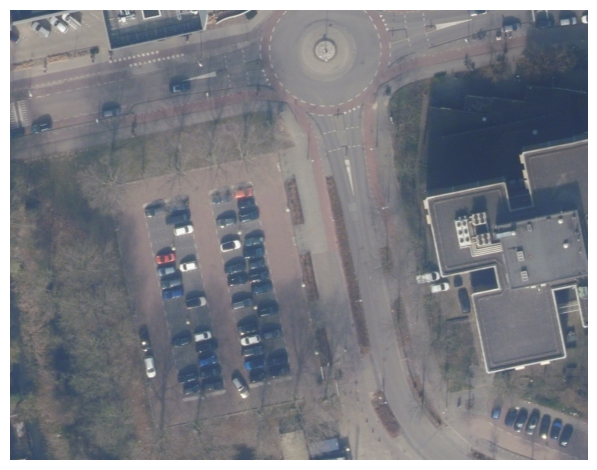

In [64]:
from pathlib import Path
from IPython.display import display
from PIL import Image


import matplotlib.pyplot as plt

p = "image.png"
image = Image.open("image.png")

plt.imshow(image)
plt.axis("off")
plt.tight_layout()
plt.show()

In [65]:
from transformers import Sam3Processor, Sam3Model
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def compute_orientation(mask, threshold=0.5):
    """
    Estimate orientation using PCA on mask pixels.
    Returns (angle_deg, centroid_xy, major_len, minor_len) or None if empty.
    angle_deg: degrees from image +x axis (right) positive CCW.
    centroid_xy: (x, y) in image coordinates.
    """
    if torch.is_tensor(mask):
        arr = mask.cpu().numpy()
    else:
        arr = np.array(mask)

    # normalize to boolean
    if arr.dtype == np.uint8 or arr.max() > 1:
        bw = arr > 127
    else:
        bw = arr > threshold

    coords = np.column_stack(np.where(bw))  # rows (y), cols (x)
    if coords.size == 0:
        return None

    centroid = coords.mean(axis=0)  # (y, x)
    centered = coords - centroid
    if centered.shape[0] < 2:
        return None

    cov = np.cov(centered, rowvar=False)  # 2x2 cov of [y, x]
    eigvals, eigvecs = np.linalg.eigh(cov)
    # largest eigenvalue -> principal axis
    idx = np.argmax(eigvals)
    major_vec = eigvecs[:, idx]  # [vy, vx]
    # convert to (vx, vy) and normalize
    vx, vy = float(major_vec[1]), float(major_vec[0])
    norm = np.hypot(vx, vy) or 1.0
    vx /= norm; vy /= norm

    angle_rad = np.arctan2(vy, vx)
    angle_deg = np.degrees(angle_rad)

    # approximate axis lengths from eigenvalues (scale factor arbitrary)
    major_len = 2.0 * np.sqrt(max(eigvals[idx], 0.0))
    minor_len = 2.0 * np.sqrt(max(eigvals[1-idx], 0.0))

    # centroid in (x, y)
    centroid_xy = (float(centroid[1]), float(centroid[0]))
    return angle_deg, centroid_xy, major_len, minor_len

def overlay_masks(image, masks, draw_orientations=True):
    image = image.convert("RGBA")
    masks_np = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks_np.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    orientations = []
    for mask, color in zip(masks_np, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

        # compute orientation for this mask
        orient = compute_orientation(mask)
        orientations.append((orient, color))

    if draw_orientations:
        draw = ImageDraw.Draw(image)
        for item in orientations:
            orient, color = item
            if orient is None:
                continue
            angle_deg, (cx, cy), major_len, minor_len = orient
            # draw a line for the major axis (scaled for visibility)
            L = max(20, major_len * 4)
            # direction vector
            ang = np.radians(angle_deg)
            dx = np.cos(ang) * L
            dy = np.sin(ang) * L
            # image coordinates: x right, y down (PIL uses same)
            start = (cx - dx, cy - dy)
            end = (cx + dx, cy + dy)
            draw.line([start, end], fill=(255,255,255,255), width=3)
            # small circle at centroid
            r = 4
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(255,255,255,255))

    return image, orientations

def minimal_axis_angle_diff(a_deg, b_deg):
    """
    Return smallest absolute angle difference between two axial angles (degrees).
    Accounts for 180-degree axis ambiguity and returns value in [0, 90].
    """
    # minimal difference on circle
    raw = abs(((a_deg - b_deg + 180) % 360) - 180)  # in [0,180]
    if raw > 90:
        raw = 180 - raw
    return raw



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]


Detecting cars and estimating their orientations...
Initially found 66 car objects. Filtering by aspect ratio and area...
Found 57 car objects after filtering
Car 0: angle=-13.0°, centroid=(1316.5492385786802, 45.877157360406095), major=27.8, minor=11.5
Car 1: angle=-11.7°, centroid=(631.5875796178344, 866.9179936305733), major=29.5, minor=13.8
Car 2: angle=-6.2°, centroid=(636.3187347931873, 894.6143552311436), major=33.9, minor=15.9
Car 3: angle=-10.8°, centroid=(487.73342836778335, 767.7512473271561), major=30.9, minor=14.8
Car 4: angle=-24.6°, centroid=(451.229904440697, 864.3552557616639), major=29.6, minor=19.4
Car 5: angle=-11.7°, centroid=(653.2585616438356, 694.9155251141552), major=30.1, minor=18.8
Car 6: angle=-83.3°, centroid=(82.5795081967213, 303.96147540983605), major=67.3, minor=28.0
Car 7: angle=-10.1°, centroid=(639.7893258426966, 633.7067415730337), major=32.7, minor=17.9
Car 8: angle=-71.1°, centroid=(1341.5324189526184, 1075.4576059850374), major=35.3, minor=14.7


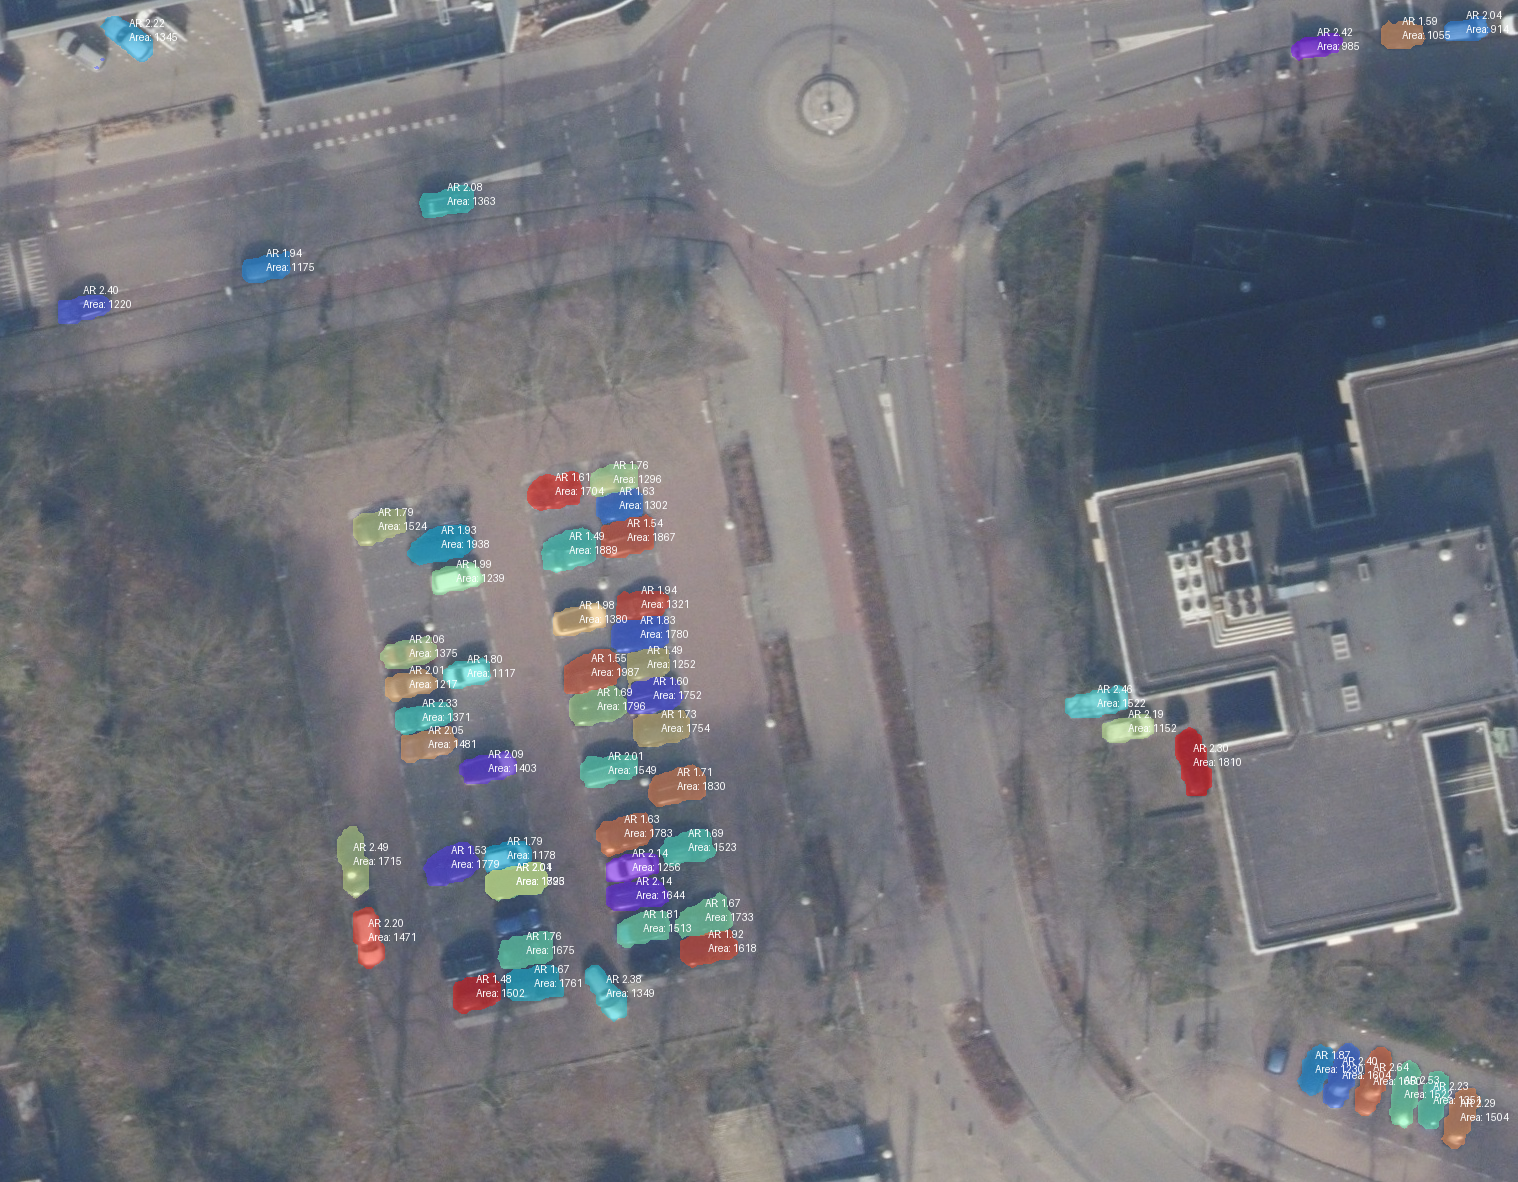

In [66]:
# detect cars and estimate orientations
from IPython.display import display
print("\nDetecting cars and estimating their orientations...")

inputs_cars = processor(images=image, text="car body", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_cars = model(**inputs_cars)

results_cars = processor.post_process_instance_segmentation(
    outputs_cars,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_cars.get("original_sizes").tolist()
)[0]

print(f"Initially found {len(results_cars['masks'])} car objects. Filtering by aspect ratio and area...")

# --- Filter by aspect ratio and area ---
keep_indices = []
min_aspect_ratio = 1.3
max_aspect_ratio = 2.8
min_area = 800  # Minimum area in pixels to be considered a car
max_area = 2000 # Maximum area in pixels to exclude trucks

for i, mask in enumerate(results_cars["masks"]):
    # Calculate area
    if torch.is_tensor(mask):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)
    
    # Check if mask is boolean or 0-1 or 0-255
    if mask_np.dtype == bool:
        area = np.sum(mask_np)
    else:
        area = np.sum(mask_np > 0)
        
    if area < min_area or area > max_area:
        continue

    orient = compute_orientation(mask)
    if orient is None:
        continue
    _, _, major_len, minor_len = orient
    if minor_len < 1.0: # Avoid division by zero
        continue
    
    aspect_ratio = major_len / minor_len
    if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
        keep_indices.append(i)

# Apply filter
results_cars["masks"] = results_cars["masks"][keep_indices]
results_cars["scores"] = results_cars["scores"][keep_indices]
if "labels" in results_cars:
    results_cars["labels"] = results_cars["labels"][keep_indices]

print(f"Found {len(results_cars['masks'])} car objects after filtering")

cars_image, car_orientations = overlay_masks(image, results_cars["masks"], draw_orientations=False)
draw = ImageDraw.Draw(cars_image)

for i, (orient, _) in enumerate(car_orientations):
    if orient is None:
        print(f"Car {i}: no mask pixels")
    else:
        # Calculate area for display
        mask = results_cars["masks"][i]
        if torch.is_tensor(mask):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = np.array(mask)
        
        if mask_np.dtype == bool:
            area = np.sum(mask_np)
        else:
            area = np.sum(mask_np > 0)

        angle_deg, centroid_xy, major_len, minor_len = orient
        print(f"Car {i}: angle={angle_deg:.1f}°, centroid={centroid_xy}, major={major_len:.1f}, minor={minor_len:.1f}")
        
        if minor_len > 0:
            ar = major_len / minor_len
            # Draw aspect ratio and area above the centroid
            text = f"AR: {ar:.2f}\nArea: {area}"
            draw.text((centroid_xy[0], centroid_xy[1] - 20), text, fill="white")

display(cars_image)

In [67]:
# --- roads detection (kept for visualization & filtering) --- #
print("\nDetecting roads...")

# prepare inputs for 'roads'
inputs_roads = processor(images=image, text="street road", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_roads = model(**inputs_roads)

results_roads = processor.post_process_instance_segmentation(
    outputs_roads,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_roads.get("original_sizes").tolist()
)[0]

print(f"Found {len(results_roads['masks'])} road objects")

# road masks as numpy (H, W) bool
road_masks = results_roads["masks"]
if torch.is_tensor(road_masks):
    road_masks_np = road_masks.cpu().numpy().astype(bool)
else:
    road_masks_np = np.array(road_masks).astype(bool)

# Just overlay road masks (no angle logic)
road_image, road_orientations = overlay_masks(image, results_roads["masks"], draw_orientations=False)

### --- REMOVE CARS THAT ARE ON ROADS (DISTANCE-BASED) --- ###
print("\n=== Filtering out cars that are on roads (distance-based) ===")

car_masks = results_cars["masks"]
on_road_flags = []

# Precompute union road mask and distance transform for "off-road" detection
if road_masks_np.size == 0:
    union_road = None
    dist_map = None
    print("No road masks available, skipping road-based filtering.")
else:
    from scipy.ndimage import distance_transform_edt

    union_road = road_masks_np.any(axis=0)  # (H, W) bool

    # Distance map: for each non-road pixel, distance to nearest road pixel.
    # distance = 0 inside road; grows as you move away.
    dist_map = distance_transform_edt(~union_road)

# Threshold in pixels: if car centroid is within this distance of a road, treat as on-road
road_dist_thresh = 40.0  # tweak as needed

for i, mask in enumerate(car_masks):
    if torch.is_tensor(mask):
        car_mask_np = mask.cpu().numpy()
    else:
        car_mask_np = np.array(mask)

    # binarize car mask
    if car_mask_np.dtype == bool:
        car_bin = car_mask_np
    else:
        car_bin = car_mask_np > 0

    car_area = car_bin.sum()
    if car_area == 0 or dist_map is None:
        # if no area or no roads, treat as off-road
        on_road_flags.append(False)
        continue

    # centroid from mask
    ys, xs = np.where(car_bin)
    cy = int(round(ys.mean()))
    cx = int(round(xs.mean()))

    # clamp to image bounds
    h, w = dist_map.shape
    cy = max(0, min(h - 1, cy))
    cx = max(0, min(w - 1, cx))

    dist_to_road = dist_map[cy, cx]

    # consider "on road" if centroid lies close to a road
    on_road = dist_to_road <= road_dist_thresh
    on_road_flags.append(on_road)

n_on_road = sum(on_road_flags)
print(f"Cars near roads (filtered out): {n_on_road}")
print(f"Cars off roads (kept for clustering): {len(on_road_flags) - n_on_road}")

### --- CLUSTER OFF-ROAD CARS INTO GROUPS AND VISUALIZE --- ###
print("\n=== Clustering OFF-ROAD cars into groups ===")

if len(car_orientations) == 0:
    print("No cars detected - cannot cluster.")
    clustered_image = cars_image.copy()
else:
    # collect centroids for off-road cars only
    offroad_centroids = []
    offroad_indices = []  # indices into car_orientations / results_cars

    for i, (orient, _) in enumerate(car_orientations):
        if on_road_flags[i]:
            continue  # skip cars that are on roads

        if orient is not None:
            _, centroid, _, _ = orient
            offroad_centroids.append(centroid)
            offroad_indices.append(i)
        else:
            # approximate centroid from mask if orientation is missing
            mask = results_cars["masks"][i]
            if torch.is_tensor(mask):
                mask_np = mask.cpu().numpy()
            else:
                mask_np = np.array(mask)
            ys, xs = np.where(mask_np > 0)
            if len(xs) == 0:
                continue
            offroad_centroids.append((float(xs.mean()), float(ys.mean())))
            offroad_indices.append(i)

    if len(offroad_centroids) == 0:
        print("No off-road cars to cluster.")
        clustered_image = cars_image.copy()
    else:
        offroad_centroids = np.array(offroad_centroids)

        # DBSCAN with permissive settings: every off-road car belongs to some cluster
        eps = 150  # pixels
        min_samples = 1  # this forces every point to belong to a cluster
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(offroad_centroids)
        labels = clustering.labels_

        unique_labels = sorted(set(labels))
        print(f"Total off-road cars: {len(offroad_centroids)}")
        print(f"Number of clusters (including singletons): {len(unique_labels)}")

        # create visualization image (start from original image)
        clustered_image = image.copy().convert("RGBA")
        draw = ImageDraw.Draw(clustered_image)

        # create visualization image (start from original image)
        clustered_image = image.copy().convert("RGBA")

        # also lightly show roads in the background
        roads_vis, _ = overlay_masks(image.copy(),  # use original image
                                    results_roads["masks"],
                                    draw_orientations=False)
        clustered_image = roads_vis.convert("RGBA")  # Convert back to RGBA!
        draw = ImageDraw.Draw(clustered_image)

        # color palette for clusters
        base_colors = [
            (255, 0, 0),
            (0, 255, 0),
            (0, 0, 255),
            (255, 255, 0),
            (255, 0, 255),
            (0, 255, 255),
            (255, 128, 0),
            (128, 0, 255),
            (0, 128, 255),
            (128, 255, 0),
        ]

        from scipy.spatial import ConvexHull

        # Create a transparent overlay layer
        overlay = Image.new('RGBA', clustered_image.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        for lbl in unique_labels:
            # all off-road cars in this cluster
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            color = base_colors[lbl % len(base_colors)] if lbl != -1 else (200, 200, 200)

            # get centroids for this cluster
            cluster_points = offroad_centroids[idxs]
            
            # draw convex hull around cluster
            if len(cluster_points) >= 3:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points[hull.vertices]
                polygon = [tuple(point) for point in hull_points]
                overlay_draw.polygon(polygon, fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency
            elif len(cluster_points) == 2:
                p1, p2 = cluster_points
                padding = 20
                overlay_draw.line([tuple(p1), tuple(p2)], fill=color + (255,), width=3)
                for p in cluster_points:
                    overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                                outline=color + (255,), width=3)
            else:
                p = cluster_points[0]
                padding = 30
                overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                            fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency

        # Composite the overlay onto the base image
        clustered_image = Image.alpha_composite(clustered_image, overlay)
        draw = ImageDraw.Draw(clustered_image)

        # Now draw the cluster labels on top
        for lbl in unique_labels:
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            cluster_center = offroad_centroids[idxs].mean(axis=0)
            label_text = f"C{lbl if lbl >= 0 else 'N'} ({len(idxs)})"
            draw.text((cluster_center[0], cluster_center[1]),
                    label_text,
                    fill=(255, 255, 255, 255))

print("Clustering and visualization complete.")


Detecting roads...
Found 1 road objects

=== Filtering out cars that are on roads (distance-based) ===
Cars near roads (filtered out): 5
Cars off roads (kept for clustering): 52

=== Clustering OFF-ROAD cars into groups ===
Total off-road cars: 52
Number of clusters (including singletons): 5
Clustering and visualization complete.


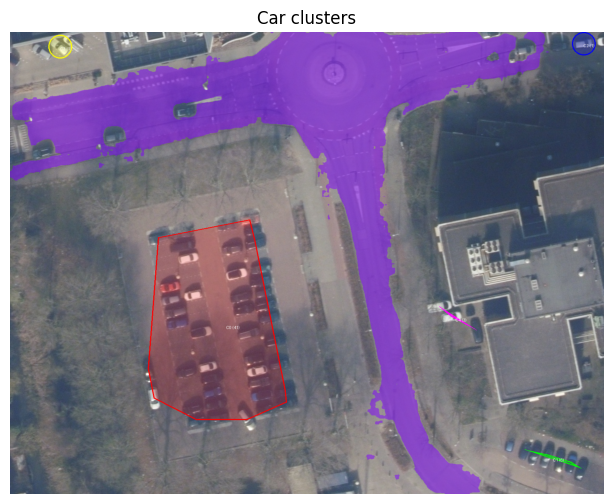

In [68]:
plt.figure(figsize=(12, 6))
plt.imshow(clustered_image)
plt.axis("off")
plt.title("Car clusters")
plt.show()